### **PROJECT TITLE- Rice Leaf Disease Detection using Deep Learning**



##### **Domain**- Agriculture, Policy makers(Government)


#### Overview:   
   * Rice is one of the most important food crops. It is crucial staple food feeding millions and one of the major driving force in the indian economy.
   * Diseases affecting rice leaves can significantly reduce crop yield.
   * Manual identification of diseases is time-consuming and error-prone. hence,
   * This project aims to classify three major rice leaf diseases:
       1) Bacterial leaf blight
       2) Brown spot
       3) Leaf smut

     using Convolutional Neural Networks (CNN).

### **PHASE 1: Project Initialization**

#### STEP 1: Importing necessesary Libraries and loading our dataset

In [1]:
import keras
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
base_path=r"D:\DATAMITES PROJECTS\Projects\PRCP-1001-RiceLeaf\Data"
classes = {
    'Bacterial leaf blight': os.path.join(base_path,"Bacterial leaf blight"),
    "Brown spot": os.path.join(base_path,"Brown spot"),
    "Leaf smut": os.path.join(base_path,"Leaf smut")
}


for class_name, path in classes.items():
    image_count = len(os.listdir(path))
    print(f"{class_name}: {image_count} images")


Bacterial leaf blight: 40 images
Brown spot: 40 images
Leaf smut: 39 images


#### ***Basic Inference from the Dataset***


* During dataset verification, it was observed that the Leaf smut class contains
39 images, while the other two classes contain 40 images each. This results in a
minor class imbalance.

* Since the difference is minimal, the imbalance is handled using data
augmentation techniques during model training.

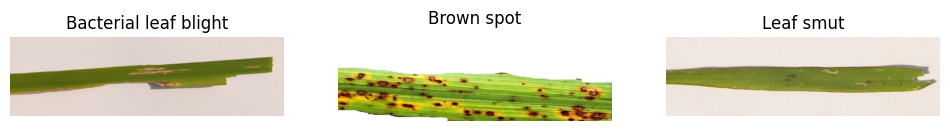

In [3]:
plt.figure(figsize=(12,4))

for idx, (class_name, path) in enumerate(classes.items()):
    img_name = os.listdir(path)[0]
    img_path = os.path.join(path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()



#### **STEP 2:**
  * Lets load the same data using Keras.
  * OpenCV is useful for human understanding (EDA) whereas Keras is feasible for training our model (machine understanding).

In [4]:
import keras
from keras import layers

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

dataset = keras.utils.image_dataset_from_directory(
    directory=base_path,
    labels="inferred",
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    verbose=True
)

Found 119 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


----------------------------------------------------------------------------------------------------------------------------------

### **PHASE 2** : Dataset Splitting and Pipeline initialization


#### Objective:

 1) To prepare the dataset for training by:
    * Splitting into Train / Validation.
    * Avoiding data leakage
    * Note: A separate test set was not created due to the limited dataset size.


 2) And setting up a clean Keras 3 pipeline

#### 1) Splitting our dataset into training and validation set

In [6]:
import keras
BATCH_SIZE = 16
IMAGE_SIZE = (224,224)
SEED = 42

train_ds = keras.utils.image_dataset_from_directory(    # training set
    directory=base_path,
    labels="inferred",
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

Found 119 files belonging to 3 classes.


Using 96 files for training.


In [7]:
val_ds = keras.utils.image_dataset_from_directory(    # validation set
    directory=base_path,
    labels="inferred",
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

Found 119 files belonging to 3 classes.
Using 23 files for validation.


In [8]:
for images, _ in train_ds.take(1):
    print(images.dtype)
    print(images.numpy().min(), images.numpy().max())

<dtype: 'float32'>
0.0 255.0


#### 2) Performance Optimization
Dataset performance is optimized by prefetching in order
to improve training speed.

In [9]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

----------------------------------------------------------------------------------------------------------------------------------

### **PHASE 3: Model Building**


#### EXPERIMENT 1 : BUILDING A BASELINE CNN MODEL


1) **Objective :**

The goal is to build a baseline Convolutional Neural Network (CNN) model in order to establish a reference before applying advanced techniques such as data augmentation,regularization,transfer learning.


2) **Architecture :**

The baseline CNN consists of:
   - Input normalization
   - Convolution + MaxPooling blocks
   - Fully connected layers
   - Softmax output for multi-class classification.

In [ ]:
from keras import layers, models

NUM_CLASSES = 3

inputs = layers.Input(shape=(224, 224, 3))

# normalization
x = layers.Rescaling(1./255)(inputs)

# Conv Block 1
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 2
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 3
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_no_aug = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_no_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Training process
first_model_no_aug = model_no_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.4271 - loss: 2.3542 - val_accuracy: 0.2174 - val_loss: 1.6826
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.4479 - loss: 1.0324 - val_accuracy: 0.5217 - val_loss: 0.9856
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.5417 - loss: 0.8561 - val_accuracy: 0.4348 - val_loss: 1.0819
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.6146 - loss: 0.8188 - val_accuracy: 0.4783 - val_loss: 1.0929
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.6562 - loss: 0.7425 - val_accuracy: 0.7391 - val_loss: 0.7548
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.7812 - loss: 0.6000 - val_accuracy: 0.6087 - val_loss: 0.9911
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.7500 - loss: 0.5869 - val_accuracy: 0.7826 - val_loss: 0.7442
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.8021 - loss: 0.5102 - val_accuracy: 0.7826 - val_loss:

***INSIGHT:***
     
   * This is the classic example for overfitting.
   * The model trained and achieved nearly 100% training accuracy but showed poor generalization, 
with validation accuracy dropping to approximately 70% and validation loss increasing significantly. 
This indicates severe overfitting.
   * The training loss decreased sharply, while the validation loss fluctuated and remained comparatively high.


   -------------------------------------------------------------------------------------------------------------------------------


#### EXPERIMENT 2: Building a CNN with DATA AUGMENTATION


1) **Objective :** 

Previous model was severly affected by over fitting issue thus 
to overcome this problem we use data augmentation technique which used to analyze new variations at every epoch and also learns robust features.


2) **The following data augmentation techniques are applied:**

    - Random horizontal flipping
    - Random rotation
    - Random zoom
    - Random contrast adjustment

These transformations simulate real-world variations such as camera
angle changes, leaf orientation, and lighting conditions.

In [13]:
from keras import layers

augment_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
]

In [14]:
from keras import layers, models

NUM_CLASSES = 3

inputs = layers.Input(shape=(224, 224, 3))

x = inputs

# Data augmentation (training only)
for aug in augment_layers:
    x = aug(x)

# Normalization
x = layers.Rescaling(1./255)(x)

# Conv Block 1
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 2
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2,2)(x)

# Conv Block 3
x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2,2)(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_aug = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Training process
second_model_aug = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.2917 - loss: 3.0330 - val_accuracy: 0.2174 - val_loss: 1.1135
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.3646 - loss: 1.1049 - val_accuracy: 0.2174 - val_loss: 1.1428
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.4062 - loss: 1.0748 - val_accuracy: 0.3478 - val_loss: 1.1337
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.4167 - loss: 1.0376 - val_accuracy: 0.3478 - val_loss: 1.1856
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - accuracy: 0.4792 - loss: 0.9857 - val_accuracy: 0.3478 - val_loss: 1.0567
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.4792 - loss: 0.9885 - val_accuracy: 0.3478 - val_loss: 1.1249
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.5729 - loss: 0.9568 - val_accuracy: 0.3043 - val_loss: 1.3407
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.5417 - loss: 0.9128 - val_accuracy: 0.4348 - val_loss:

***INSIGHT:***

Experimental results show that data augmentation plays a critical role in improving model generalization. While the CNN trained on original images suffered from overfitting, the augmented model achieved noticeably better validation performance.

----------------------------------------------------------------------------------------------------------------------------------


#### EXPERIMENT 3: CNN with REGULARIZATION

1) **Objectives:**
    * Reduce overfitting further
    * Stabilize training
    * Improve consistency across runs


2) **The following Regularization techniques are applied:**

    * Dropout
    * Batch normalization

In [17]:
from keras import layers, models

NUM_CLASSES = 3

inputs = layers.Input(shape=(224, 224, 3))

x = inputs

#  Data Augmentation (training only)
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.RandomContrast(0.1)(x)

#  Normalization
x = layers.Rescaling(1./255)(x)

#  Conv Block 1
x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)

#  Conv Block 2
x = layers.Conv2D(64, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)

#  Conv Block 3
x = layers.Conv2D(128, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)

#  Classifier
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)   #  Regularization
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_reg = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_reg.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Training process
third_model_reg=model_reg.fit(train_ds,validation_data=val_ds,epochs=20)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 878ms/step - accuracy: 0.3750 - loss: 49.4995 - val_accuracy: 0.3043 - val_loss: 1.9046
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 724ms/step - accuracy: 0.5208 - loss: 9.8300 - val_accuracy: 0.1304 - val_loss: 1.4695
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 710ms/step - accuracy: 0.5938 - loss: 7.8373 - val_accuracy: 0.2174 - val_loss: 3.9896
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 750ms/step - accuracy: 0.7188 - loss: 6.3108 - val_accuracy: 0.2174 - val_loss: 7.5106
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 787ms/step - accuracy: 0.6875 - loss: 3.7602 - val_accuracy: 0.2174 - val_loss: 6.2269
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 684ms/step - accuracy: 0.6667 - loss: 2.6373 - val_accuracy: 0.2174 - val_loss: 8.7592
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 718ms/step - accuracy: 0.6979 - loss: 2.3368 - val_accuracy: 0.2174 - val_loss: 5.9677
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 700ms/step - accuracy: 0.6562 - loss: 1.6276 - val_accuracy: 0.2174 - val_loss

***INSIGHT:***


   * Although regularization is effective in controlling overfitting, its application on a small dataset led to underfitting by over constraining the model, resulting in reduced validation performance.
   * Due to the small dataset size and limited batch
statistics, the model showed training instability and underfitting.
   * This experiment demonstrates that excessive regularization can be detrimental
for the small datasets.


----------------------------------------------------------------------------------------------------------------------------------


#### EXPERIMENT 4: Building a model with Transfer Learning technique


1) **Objective:**

   * To implement MobileNet as a pretrained feature extractor to enhance classification performance and stability when training   on a small image dataset.

2) **Transfer Learning:**
   * Transfer learning leverages knowledge learned from large-scale datasets.

3) **MobileNet:**
    * MobileNet is a lightweight pre-trained convolutional neural network designed for efficient image classification
    * Pretrained on ImageNet (millions of images)
    * Learns strong generic visual features
    * Works well even with small datasets
    * Fewer parameters than VGG/ResNet
    * Faster training
    * Lower overfitting risk

In [20]:
from keras.applications import MobileNet
from keras import layers, models


In [21]:
base_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,      # remove ImageNet classifier
    weights="imagenet"
)

base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3))

# Data augmentation
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# MobileNet preprocessing
x = layers.Rescaling(1./255)(x)

# Feature extractor
x = base_model(x, training=False)

# Custom classifier
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_mobilenet = models.Model(inputs, outputs)


In [ ]:
# Compilation process
model_mobilenet.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Training process
fourth_model_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.5833 - loss: 0.9813 - val_accuracy: 0.6087 - val_loss: 0.9456
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.7812 - loss: 0.5243 - val_accuracy: 0.6522 - val_loss: 0.8452
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.8542 - loss: 0.4349 - val_accuracy: 0.6957 - val_loss: 0.7462
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8854 - loss: 0.3202 - val_accuracy: 0.8261 - val_loss: 0.6040
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9271 - loss: 0.1861 - val_accuracy: 0.7391 - val_loss: 0.5947
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9271 - loss: 0.2076 - val_accuracy: 0.8261 - val_loss: 0.5439
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.9479 - loss: 0.1402 - val_accuracy: 0.8261 - val_loss: 0.5004
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9583 - loss: 0.1152 - val_accuracy: 0.8696 - val_loss:

***INSIGHT:*** 

1) Fast convergence

* Validation accuracy jumps from 52% → 78% → 87% → 91%.
* Happens within 5–9 epochs.

2) Strong generalization

* Validation loss continuously decreases.
* No sudden explosion like earlier regularized CNN.
* Minor fluctuations are normal due to small data.

3) Mild overfitting, but controlled

* Training accuracy goes close to 100%.
* Validation accuracy stays high 87% (approx).


MobileNet was pre-trained on ImageNet and already learned generic
low-level and mid-level visual features. Using it as a frozen feature
extractor allowed the model to generalize better on a small dataset.


----------------------------------------------------------------------------------------------------------------------------------


### **PHASE 4: Final Report**

##### **Report 1: Models built**

   1) A baseline CNN
   2) CNN with Data Augmentation
   3) CNN with Regularization technique
   4) Transfer Learning using MobileNet


##### **Report 2: Model comparison**

We are comparing the model based on Validation accuracy and validation Loss because validation accuracy tells how well the model classify unseen data and validation loss shows how confident and stable our are the model's prediction.


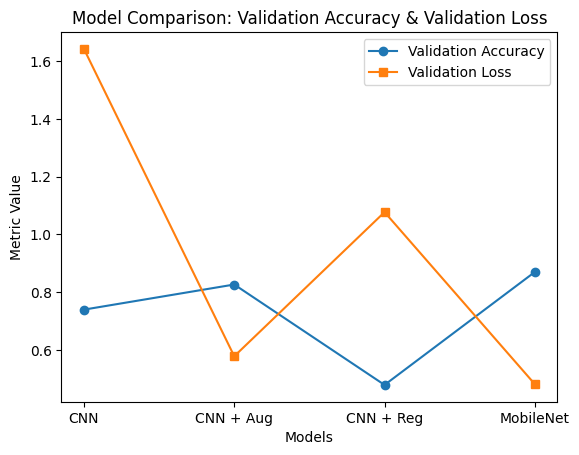

In [15]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "CNN",
    "CNN + Aug",
    "CNN + Reg",
    "MobileNet"
]

val_accuracy = [0.7391, 0.8261, 0.4783, 0.8696]
val_loss = [1.6422, 0.5776, 1.0769, 0.4808]

x = np.arange(len(models))

plt.figure()

plt.plot(x, val_accuracy, marker='o', label="Validation Accuracy")
plt.plot(x, val_loss, marker='s', label="Validation Loss")

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Metric Value")
plt.title("Model Comparison: Validation Accuracy & Validation Loss")
plt.legend()
plt.show()


Model 1: Clearly Overfitting due to very high loss with moderate accuracy.

Model 2: balanced but not best

Model 3: severe underfitting due to low accuracy + high loss.

Model 4: MobileNet achieves the highest validation accuracy, proving the effectiveness of transfer learning on small datasets.

#### **Report 3: Challenges faced**

1) Very small Dataset: 
   * Dataset contains only 119 images which is highly difficult to make a stable model.
   * High risk of overfitting and poor generalization.
   * Even Regularization method were severly affected by Underfitting
2) Selecting the Best Model for Production:
   * Custom CNNs struggled due to limited data.
   * Need a model that generalizes well despite small dataset size.
3) Model Comparison:
   * Training metrics were misleading due to overfitting.

   -------------------------------------------------------------------------------------------------------------------------------


#### **CONCLUSION:**
* The proposed deep learning–based solution demonstrates the potential of AI-driven tools in supporting precision agriculture.
* In this project, multiple deep learning models were developed and evaluated to classify rice leaf diseases. 
* Among all models, MobileNet with transfer learning achieved the best performance, showing high validation accuracy and low validation loss. 
* The study highlighted the effects of overfitting, underfitting, data augmentation,regularization and transfer learning on small image datasets.

-------------------------------------------------------------------**END**--------------------------------------------------------------------------------------

In [ ]:
# FOR LOADING OUR MODEL WITH PRE-TRAINED PARAMETERS
import tensorflow as tf
from tensorflow.keras.models import load_model
model_aug = load_model('saved_models/cnn_with_augmentation.keras')
model_no_aug = load_model('saved_models/cnn_no_augmentation.keras')
model_reg = load_model('saved_models/cnn_with_regularization.keras')
model_mobilenet = load_model('saved_models/mobilenet_transfer_learning.keras')